In [57]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [58]:
time_start = time.time()

In [59]:
b = BLEPipeline()

In [60]:
# Uncomment when new traffic is collected. Keep commented otherwise to prevent overwriting current csv files
# b.extract_packet_features(create_master=True)

In [61]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


## Data Exploration

In [62]:
sns.set_palette(sns.color_palette("GnBu_d"))

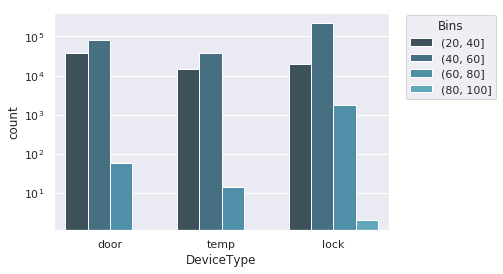

In [63]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['PacketLength'], bins=[20, 40, 60, 80, 100]));
g.set_yscale('log')
plt.legend(loc='upper_right');
plt.legend(title='Bins', bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0.);
plt.savefig('Results/Plots/ble-packetlength.png', bbox_inches='tight')

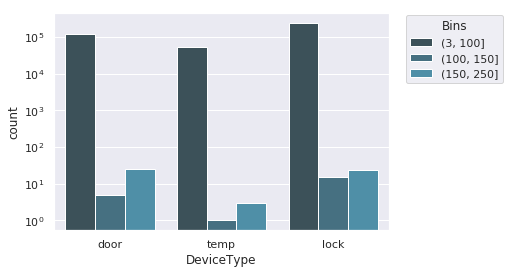

In [64]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['BLE_LL_Length'], bins=[3,100,150,250]));
g.set_yscale('log')
plt.legend(title='Bins', bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0.);
plt.savefig('Results/Plots/ble-blelllength.png', bbox_inches='tight')

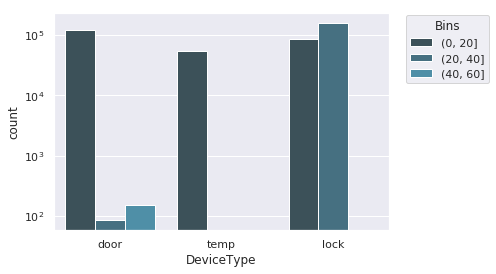

In [65]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['Assoc_Packets'], bins=[0,20,40,60]));
g.set_yscale('log')
plt.legend(title='Bins', bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0.);
plt.savefig('Results/Plots/ble-assocpackets.png', bbox_inches='tight')

0     165804
39    133898
12    118819
Name: RFChannel, dtype: int64


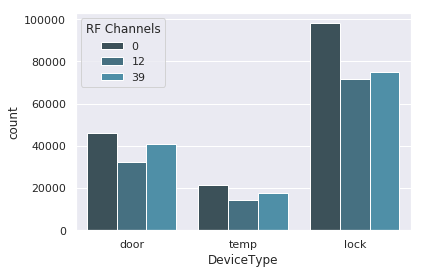

In [66]:
g = sns.countplot(x=df["DeviceType"], hue=df["RFChannel"]);
print df['RFChannel'].value_counts()
plt.legend(title='RF Channels', loc='upper_left');
plt.savefig('Results/Plots/ble-rfchannel.png', bbox_inches='tight')

ADV_IND            323515
SCAN_RSP            79045
SCAN_REQ            15530
ADV_NONCONN_IND       373
ADV_DIRECT_IND         45
ADV_SCAN_IND            9
CONNECT_REQ             4
Name: PDUType, dtype: int64


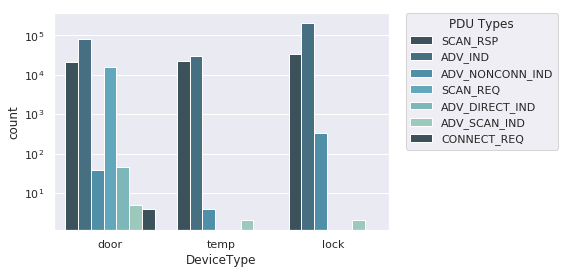

In [67]:
# sns.set_palette(sns.color_palette("gray"))
g = sns.countplot(x=df["DeviceType"], hue=df["PDUType"], palette=sns.color_palette("GnBu_d"));
print df['PDUType'].value_counts()
g.set_yscale('log')
plt.legend(title='PDU Types', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.savefig('Results/Plots/ble-pdutype.png', bbox_inches='tight')

In [68]:
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length",
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

## Resample

### Downsampling

In [69]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

### Create trial dataframes

In [70]:
df_trials = []
num_trials = 25
while len(df_trials) != num_trials:
    df_downsampled = b.downsample(X, y, df[df["Set"]=="test"])

    # Ensure that the trial sample contains all features in feature list
    if set(features_list).issubset(set(df_downsampled.columns)):
        df_trials.append(df_downsampled)

## Run trials

In [71]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = b.one_vs_all_classify(trial, [x for x in features_list if x in trial.columns], y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25


## Reports

### Report AUC

In [72]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []
for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()
    
    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)
            
            
            # Plot ROC curve
#             title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
#             skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
#                                    classes_to_plot=[1], figsize=(8,6));
            

### Print csv reports

In [73]:
df_alloutput = b.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/ble-alltrials.csv', mode='w')

In [74]:
cm_metrics = ['TP','FP','FN','TN']
performance_metrics = ['Accuracy', 'Precision','Recall','AUC']

df_meancm = pd.DataFrame(columns=b.get_header(cm_metrics))
df_meanmetrics = pd.DataFrame(columns=b.get_header(performance_metrics))

devalg_combinations = [(x,y) for x in df_alloutput['Device'].unique() for y in df_alloutput['Classifier'].unique()]
for x in devalg_combinations:    
    # Report mean confusion matrix
    cm = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), cm_metrics]
    mean_cm = b.get_mean_metric(cm, cm_metrics)
    mean_cm_series = pd.Series(data=mean_cm, name=str(x), index=df_meancm.columns)
    df_meancm = df_meancm.append(mean_cm_series)
    
    # Report mean performance metrics
    metrics = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), performance_metrics]
    mean_metrics = b.get_mean_metric(metrics, performance_metrics)
    mean_metrics_series = pd.Series(data=mean_metrics, name=str(x), index=df_meanmetrics.columns)
    df_meanmetrics = df_meanmetrics.append(mean_metrics_series)

# Print out to csv    
df_meancm.to_csv('Results/ble-meanCM.csv', mode='w')
df_meanmetrics.to_csv('Results/ble-meanmetrics.csv', mode='w')

In [75]:
df_performance_device = b.report_metrics_across('Device', df_alloutput)
df_performance_device.to_csv('Results/ble-devtype.csv', mode='w')

In [76]:
df_performance_classifier = b.report_metrics_across('Classifier', df_alloutput)
df_performance_classifier.to_csv('Results/ble-classifier.csv', mode='w')

### Time Performance

In [77]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in y_list:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 67.1994271278 seconds
(Door, KNN) : 19.5981609821 seconds
(Door, RF) : 1.07613182068 seconds
(Door, LDA) : 0.598994970322 seconds
(Lock, KNN) : 19.4626419544 seconds
(Lock, RF) : 1.01327013969 seconds
(Lock, LDA) : 0.600522994995 seconds
(Temp, KNN) : 19.5760731697 seconds
(Temp, RF) : 0.976720094681 seconds
(Temp, LDA) : 0.597394227982 seconds

Trial  1
Total time: 71.4271998405 seconds
(Door, KNN) : 21.0389368534 seconds
(Door, RF) : 1.06927585602 seconds
(Door, LDA) : 0.592688083649 seconds
(Lock, KNN) : 21.0207650661 seconds
(Lock, RF) : 1.01202702522 seconds
(Lock, LDA) : 0.582192897797 seconds
(Temp, KNN) : 20.8946979046 seconds
(Temp, RF) : 0.998728990555 seconds
(Temp, LDA) : 0.579228878021 seconds

Trial  2
Total time: 72.2330870628 seconds
(Door, KNN) : 21.2923510075 seconds
(Door, RF) : 1.06971788406 seconds
(Door, LDA) : 0.595752954483 seconds
(Lock, KNN) : 21.076843977 seconds
(Lock, RF) : 1.00911808014 seconds
(Lock, LDA) : 0.601312875748 seconds
(Tem

### Feature Importance

In [78]:
df_featImp = pd.DataFrame()
for i,f in enumerate(b.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [79]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [80]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
feat_imp.to_csv('Results/ble-feature_importance.csv', mode='w')

### Plots

lock    245121
door    119701
temp     53699
Name: DeviceType, dtype: int64


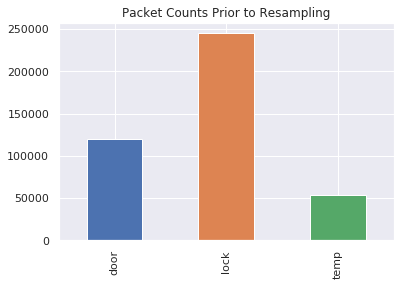

In [81]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");
print df["DeviceType"].value_counts()

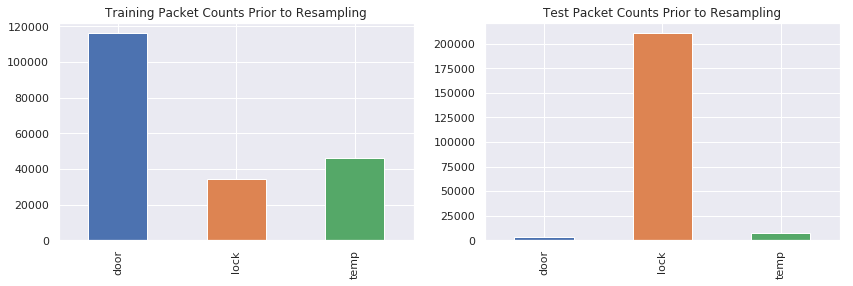

In [82]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


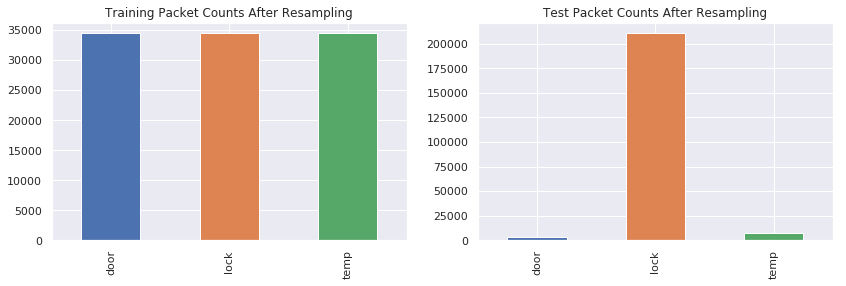

In [83]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
